In [27]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.filters import threshold_local
from PIL import Image
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage

In [28]:
#define resize function
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

#define plot gray image with the size 16x10 function
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

#define plot color image with the size 16x10 function
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

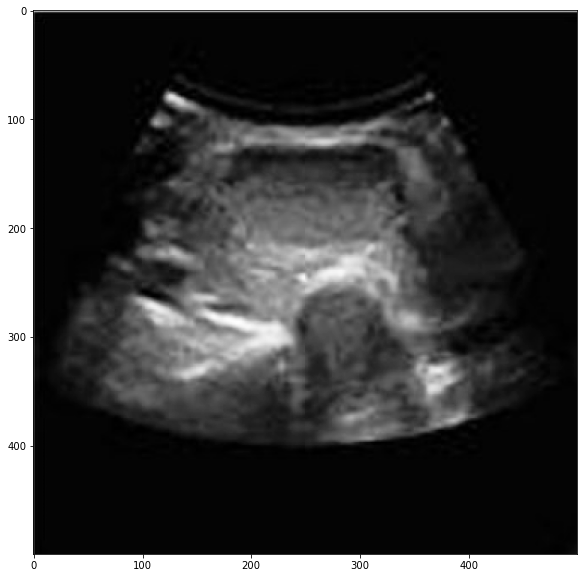

In [29]:
#get the image
file_name = 'C:/Users/Laptop88/Desktop/Thyroid Cancer untrasound images/The-single-layer-of-thyroid-ultrasound-image-after-cutting_Q320.jpg'
image = cv2.imread(file_name)
#downscale image to more efficient to find contour
resize_ratio = 500 / image.shape[0]
original=image.copy()
image = opencv_resize(image, resize_ratio)
#convert image to gray scale to easy utilise
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_gray(gray_image)

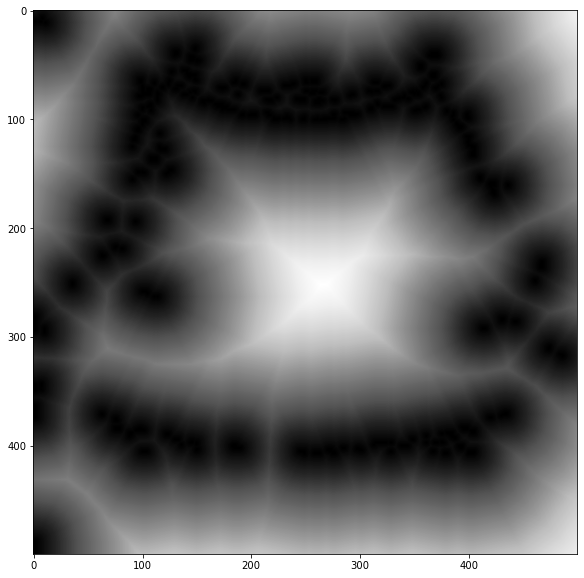

In [30]:
dist = cv2.distanceTransform(gray_image, cv2.DIST_L2, 5)
dist=cv2.normalize(dist, 0, 1.0, cv2.NORM_MINMAX)
plot_gray(dist)

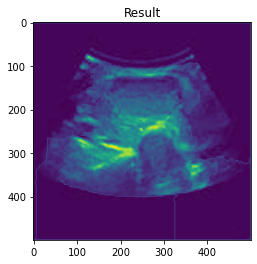

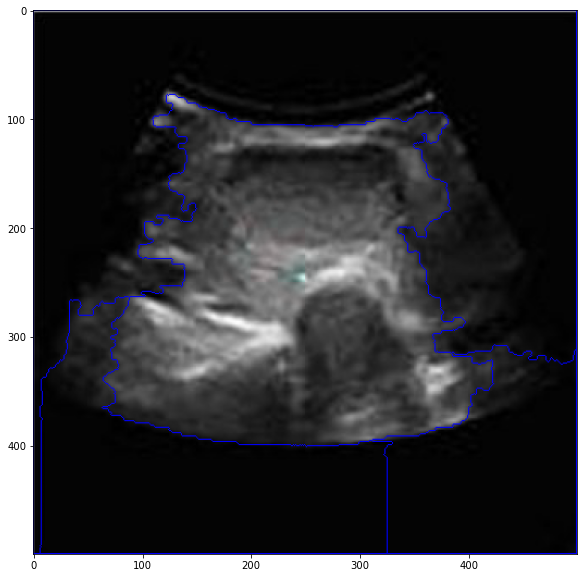

In [31]:
ret, thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
 
# Eliminate noise
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
 
 # 
sure_bg = cv2.dilate(opening, kernel, iterations=3)
 
 # 
dist_transform = cv2.distanceTransform(opening, 1, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
 
 #Get an unknown area
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
 
 # 
ret, markers1 = cv2.connectedComponents(sure_fg)
 
 # Make sure the background is 1 is not 0
markers = markers1 + 1
 
 # Unknown area marked as 0
markers[unknown == 255] = 0
 
markers3 = cv2.watershed(image, markers)
image[markers3 == -1] = [0, 0, 255]

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)),
plt.title('Result'), plt.axis('on')
plt.show()

 
plot_rgb(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

<ipython-input-36-ed0185fce5d1>:7: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = peak_local_max(distance_map, indices=False, min_distance=20, labels=thresh)
C:\Users\Laptop88\anaconda3\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


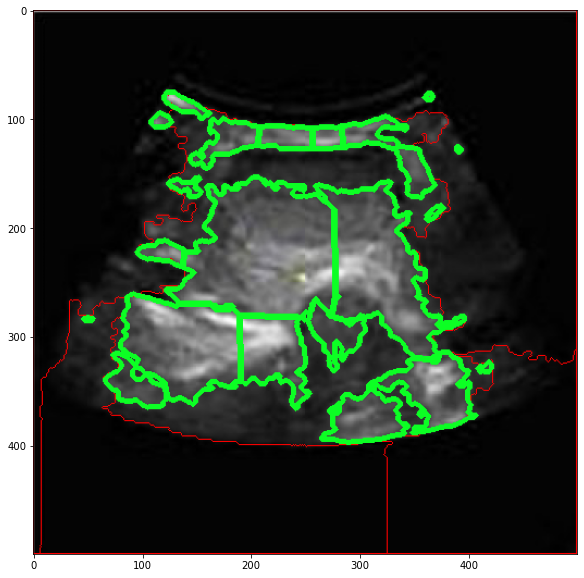

In [36]:
# Load in image, convert to gray scale, and Otsu's threshold
thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# Compute Euclidean distance from every binary pixel
# to the nearest zero pixel then find peaks
distance_map = ndimage.distance_transform_edt(thresh)
local_max = peak_local_max(distance_map, indices=False, min_distance=20, labels=thresh)

# Perform connected component analysis then apply Watershed
markers = ndimage.label(local_max, structure=np.ones((3, 3)))[0]
labels = watershed(-distance_map, markers, mask=thresh)

# Iterate through unique labels
for label in np.unique(labels):
    if label == 0:
        continue

    # Create a mask
    mask = np.zeros(gray_image.shape, dtype="uint8")
    mask[labels == label] = 255

    # Find contours and determine contour area
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    c = max(cnts, key=cv2.contourArea)
    area = cv2.contourArea(c)
    cv2.drawContours(image, [c], -1, (36,255,12), 4)
plot_rgb(image)